In [1]:
import mlrose_hiive as mlrose
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm
import time

import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

from mlrose_hiive.fitness._discrete_peaks_base import _DiscretePeaksBase

In [2]:
""" Classes for defining optimization problem objects."""

import numpy as np

from mlrose_hiive import DiscreteOpt, FourPeaks


class FourPeaksGenerator:
    """Generator class for Four Peaks."""
    @staticmethod
    def generate(seed, size=20, t_pct=0.1):
        np.random.seed(seed)
        fitness = FourPeaks(t_pct=t_pct)
        problem = DiscreteOpt(length=size, fitness_fn=fitness, maximize=True)
        return problem

In [3]:
from mlrose_hiive import RHCRunner

In [4]:
problem_size = 50 #refers to how long the bit string will be 
fourpeaks_problem = FourPeaksGenerator.generate(seed=428, size=problem_size)

#### RHCRunner with 3 random seeds and averaging over runs to determine best hyperparams 

In [5]:
seed_list = [55, 12345, 888] 

In [6]:
max_attempts = 300
restart_list = [0, 1, 2, 4, 8, 16, 32, 64]

In [14]:
def run_rhc_with_seed(seed, restart, max_attempts):
    start_time = time.time()
    rhc_runner = RHCRunner(
        problem=fourpeaks_problem,
        experiment_name="4peaks_rhc_experiment",
        output_directory=f"./seed{seed}",
        seed=seed,
        iteration_list=2 ** np.arange(8), #specific points (iterations) at which performance metrics are measured, max 256 
        max_attempts=max_attempts, #max number of attempts algo will make to find improvement in fitness value before terminating current run
        restart_list=[restart] #resets the algo from a new random initial state 
    )
    runtime = time.time() - start_time
    print(f'Runtime with seed #{seed}: {runtime}') 
    return rhc_runner.run()

# Run RHCRunner for each seed and collect results
all_run_stats = []
all_run_curves = []

for seed in tqdm(seed_list, desc="Running RHCRunner with different seeds"):
    rhc_run_stats, rhc_run_curves = run_rhc_with_seed(seed, restart, max_attempts) 
    all_run_stats.extend(rhc_run_stats)
    all_run_curves.extend(rhc_run_curves)

# Convert the results to DataFrames for analysis
rhc_run_stats_df = pd.DataFrame(all_run_stats)
rhc_run_curves_df = pd.DataFrame(all_run_curves)

Running RHCRunner with different seeds:   0%|             | 0/5 [00:00<?, ?it/s]


NameError: name 'restart' is not defined

In [13]:
rhc_run_stats_df

,0
0,Iteration
1,Fitness
2,FEvals
3,Time
4,State
5,Restarts
6,max_iters
7,current_restart
8,Iteration
9,Fitness


In [14]:
# Calculate average performance metrics
average_fitness = rhc_run_stats.groupby('Iteration')['Fitness'].mean()
average_time = rhc_run_stats.groupby('Iteration')['Time'].mean()

print("Average Fitness over Iterations:")
print(average_fitness)

print("Average Time over Iterations:")
print(average_time)

# Find the best hyperparameters based on average performance
best_run = rhc_run_stats.loc[rhc_run_stats.groupby('Iteration')['Fitness'].idxmax()]
print("Best Hyperparameters:")
print(best_run)

Average Fitness over Iterations:
Iteration
0       1.785185
1       1.785185
2       1.785185
4       1.807407
8       1.896296
16      2.125926
32      2.844444
64      3.274074
128     4.792593
256     8.000000
512    11.014815
Name: Fitness, dtype: float64
Average Time over Iterations:
Iteration
0      106.213402
1      106.463752
2      106.704265
4      106.947112
8      107.213485
16     107.492968
32     107.821252
64     108.247091
128    108.881785
256    109.814847
512    110.951735
Name: Time, dtype: float64
Best Hyperparameters:
      Iteration  Fitness  FEvals        Time  \
682           0      5.0   10475   84.100269   
683           1      5.0   10476   84.451009   
684           2      5.0   10477   84.793508   
366           4      5.0    5436   19.897937   
686           8      6.0   10484   85.619137   
1171         16     12.0   14992  193.446776   
1172         32     12.0   15008  193.943817   
1173         64     12.0   15040  194.814487   
1339        128     1

**Restarts** means that it begins the optimization process from a new, randomly selected initial state after completing a run either because it reached the max number of attempts without finding an improvement or it converged to a local optimum. This is done to escape potential local optima and explore other parts of the solution space. 

The process: 
- algo is initialized from the seed state. it performs the hill climbing process
- that run terminates when either max_attempts is reached (no improvement was found) or algo converged, which means no better neighboring state was found within the allowed attempts
- the algo then selects a new random initial state and repeats the hill climbing process

Example: at restarts=64, the algo performs 64 independent runs, each starting from a different random initial state. 

**Intuition about 4peaks and restarts**
- 4peaks likely has multiple local optima. Restarts are pivotal in ensuring that the algo doesn't get stuck in these local optima and prevent it from finding the global optimum.
- 4peaks has a lot of peaks and valleys, and benefits from exploratory behavior by starting from multiple random points so that the chance of finding a better solution is increased. A single run from one initial point is insufficient to thoroughly explore the solution space.
- having multiple restarts ensures better coverage for the solution space. however, computational time suffers so a trade-off has to be made between having more restarts and a desire for shorter computational time.
- can analyze RHC fitness scores on different number of restarts, and plot the fitness scores against the restarts to see how quickly the algo converges to better solutions with those additional restarts.

Average Fitness by Restarts:
Restarts
0     3.545455
1     4.000000
2     4.454545
4     4.472727
8     4.414141
16    4.112299
32    3.550964
64    3.545455
Name: Fitness, dtype: float64


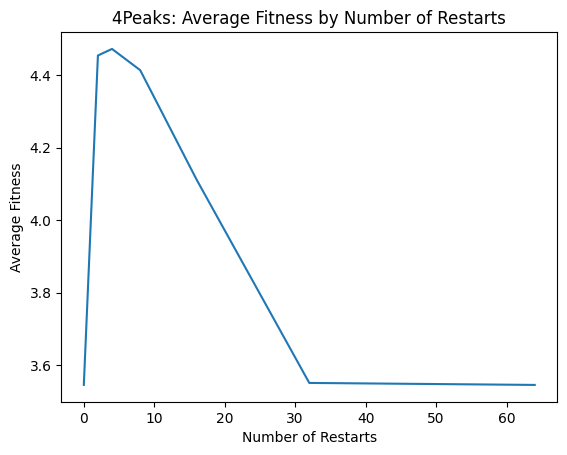

In [16]:
# Calculate average performance metrics
average_fitness = rhc_run_stats.groupby('Restarts')['Fitness'].mean()

print("Average Fitness by Restarts:")
print(average_fitness)

# Plot the average fitness by restarts
plt.plot(average_fitness)
plt.title('4Peaks: Average Fitness by Number of Restarts')
plt.xlabel('Number of Restarts')
plt.ylabel('Average Fitness')
plt.show()

   Iteration  Fitness  FEvals      Time  \
0          0      3.0       0  0.000145   
1          1      3.0       1  0.006826   
2          2      3.0       2  0.013514   
3          4      3.0       4  0.018354   
4          8      3.0       8  0.022667   

                                               State  Restarts  max_iters  \
0  [0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, ...         0        512   
1  [0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, ...         0        512   
2  [0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, ...         0        512   
3  [0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, ...         0        512   
4  [0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, ...         0        512   

   current_restart  
0                0  
1                0  
2                0  
3                0  
4                0  
   Iteration      Time  Fitness  FEvals  Restarts  max_iters  current_restart
0          0  0.000145      3.0     0.0         0        512              

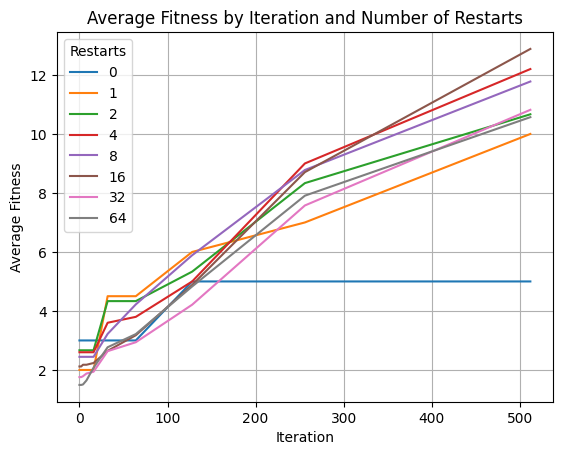

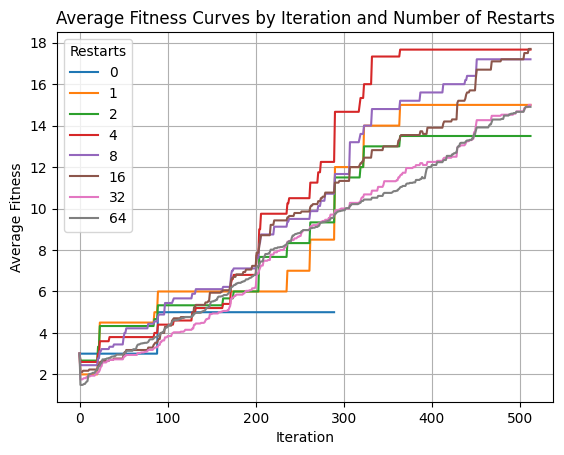

In [20]:
# Inspect the DataFrames
print(rhc_run_stats.head())
print(rhc_run_curves.head())

# Assuming rhc_run_stats contains columns like ['Iteration', 'Fitness', 'FEvals', 'Time', 'State', 'Restarts', 'max_iters', 'current_restart']
# and rhc_run_curves contains the performance curves over iterations.

# Convert necessary columns to appropriate data types if needed
rhc_run_stats['Iteration'] = pd.to_numeric(rhc_run_stats['Iteration'])
rhc_run_stats['Fitness'] = pd.to_numeric(rhc_run_stats['Fitness'])
rhc_run_stats['Restarts'] = pd.to_numeric(rhc_run_stats['Restarts'])

# Group by 'Iteration' and 'Restarts' and calculate average fitness
average_fitness = rhc_run_stats.groupby(['Iteration', 'Restarts'])['Fitness'].mean().reset_index()

# Pivot the table to make Iteration as index and Restarts as columns
pivot_table = average_fitness.pivot(index='Iteration', columns='Restarts', values='Fitness')

# Plot the results
pivot_table.plot(kind='line')
plt.title('Average Fitness by Iteration and Number of Restarts')
plt.xlabel('Iteration')
plt.ylabel('Average Fitness')
plt.legend(title='Restarts')
plt.grid(True)
plt.show()

# Additionally, we can analyze the rhc_run_curves if they contain performance metrics over time
# Assuming rhc_run_curves has columns like ['Iteration', 'Fitness', 'Restarts']

# Group by 'Iteration' and 'Restarts' and calculate average fitness over time
average_fitness_curves = rhc_run_curves.groupby(['Iteration', 'Restarts'])['Fitness'].mean().reset_index()

# Pivot the table to make Iteration as index and Restarts as columns
pivot_curves_table = average_fitness_curves.pivot(index='Iteration', columns='Restarts', values='Fitness')

# Plot the results
pivot_curves_table.plot(kind='line')
plt.title('Average Fitness Curves by Iteration and Number of Restarts')
plt.xlabel('Iteration')
plt.ylabel('Average Fitness')
plt.legend(title='Restarts')
plt.grid(True)
plt.show()


#### RHC, 0 restarts, same problem seed, but 10 random initial state seeds 